## BeatGAN: Anomalous Rhythm Detection using Adversarially Generated Time

### Abstract
Given a large-scale rhythmic time series containing mostly normal data segments (or ‘beats’), can we learn how to detect anomalous beats in an effective yet efficient way? For example, how can we detect anomalous beats from electrocardiogram (ECG) readings? Existing approaches either require excessively high amounts of labeled and balanced data for classification, or rely on less regularized reconstructions, resulting in lower accuracy in anomaly detection. Therefore, we propose BeatGAN, an unsupervised anomaly detection algorithm for time series data. BeatGAN outputs explainable results to pinpoint the anomalous time ticks of an input beat, by comparing them to adversarially generated beats. Its robustness is guaranteed by its regularization of reconstruction error using an adversarial generation approach, as well as data augmentation using time series warping. Experiments show that BeatGAN accurately and efficiently detects anomalous beats in ECG time series, and routes doctors’ attention to anomalous time ticks, achieving accuracy of nearly 0.95 AUC, 
and very fast inference (2.6 ms per beat). In addition, we show that BeatGAN accurately detects unusual motions from multivariate motion-capture time series data, illustrating its generality.

You can configure the backend to use GPU or CPU only. \
Default is using backend cpu. 

In [19]:

import spartan as st

```loadTensor``` function automatically read data from file and ```toDTensor``` function extract time and value separately from the tensor.<br/>```Timeseries``` class is designed to construct time tensor.

In [20]:
time, value = st.loadTensor(path = "inputData/ecg_timeseries_small.zip", col_types = [float, float], sep=' ').toDTensor(hastticks=True)
time_series = st.Timeseries(value, time)

### Run RPeak to segment ECG series data.

This example use ECG series data as example. Before we train the model, we need RPeak to preprocess data.<br/>
Default parameters are:<br/>
{'sampling_rate': 360, 'left_size': 120, 'right_size': 136, 'out_path': None}

In [21]:
rpeak = st.RPeak(time_series)
segments = rpeak.run()
print(f"{segments}")

DTensor(
array([[[-0.31 , -0.305, -0.295, ..., -0.33 , -0.305, -0.31 ]],

       [[-0.33 , -0.33 , -0.345, ..., -0.305, -0.32 , -0.325]],

       [[-0.365, -0.365, -0.35 , ..., -0.295, -0.295, -0.285]],

       ...,

       [[-0.305, -0.305, -0.29 , ..., -0.29 , -0.29 , -0.295]],

       [[-0.345, -0.34 , -0.325, ..., -0.265, -0.26 , -0.255]],

       [[-0.285, -0.29 , -0.285, ..., -0.26 , -0.25 , -0.25 ]]])
)


In [4]:
segments.shape

(122, 1, 256)

### Run BeatGAN as a single model

BeatGAN has two kinds of structure, CNN and RNN which is controled by parameter ```network```.

Default parameters are: <br/>
{'seq_len': 256, 'stride': 32, 'input_size': 1, 'rep_size': 20, 'batch_size': 64, 'max_epoch':5, 'lr': 0.01, 'lambda': 1
'net_type':'gru', 'layers':1, 'hidden_size':100} <br/>
You can change them be passing <key>=<value> as the doc shows.

In [5]:
beatgan_CNN = st.BeatGAN(segments, "my_beatgan_model", network="CNN")

[Conv1d(1, 32, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(512, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), Ba

c:\Users\bailean\AppData\Local\Programs\Python\Python310\lib\site-packages\spartan\model\beatgan\preprocess.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  self.data = torch.Tensor(segments)


In [6]:
trained_model = beatgan_CNN.fit()

 20%|██        | 1/5 [00:00<00:03,  1.14it/s]

0:loss_g(rec/adv):0.2697511911392212/1.0609254837036133,loss_d(real/fake):0.6866635084152222/0.668810248374939


 40%|████      | 2/5 [00:01<00:02,  1.19it/s]

0:loss_g(rec/adv):0.28365880250930786/0.27409374713897705,loss_d(real/fake):0.0/9.324905395507812


 60%|██████    | 3/5 [00:02<00:01,  1.21it/s]

0:loss_g(rec/adv):0.12203920632600784/0.4770788252353668,loss_d(real/fake):37.15271759033203/0.0024882820434868336


 80%|████████  | 4/5 [00:03<00:00,  1.17it/s]

0:loss_g(rec/adv):0.14196568727493286/0.34225767850875854,loss_d(real/fake):35.57106018066406/9.611067123790792e-17


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]

0:loss_g(rec/adv):0.11590362340211868/0.21004734933376312,loss_d(real/fake):11.977347373962402/7.070557899169216e-07


### Use PipeLine to finish the work mentioned above.

In [7]:
rpeak_params = {'sampling_rate': 360, 'left_size': 120, 'right_size': 136}
beatgan_params = {'network': 'CNN', 'seq_len': 256, 'stride': 32, 'input_size': 1, 'rep_size': 20, 'model_name': 'my_beatgan_model'}
pipeline = st.PipeLine(time_series, [(st.RPeak, rpeak_params), ((st.Train, st.TrainPolicy.BeatGAN), beatgan_params)])

We will get a trained model after calling ```run``` function of ```pipeline```.

In [8]:
pipeline.run()

[Conv1d(1, 32, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(512, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), Ba

 20%|██        | 1/5 [00:00<00:03,  1.31it/s]

0:loss_g(rec/adv):0.8424623608589172/1.0738736391067505,loss_d(real/fake):0.43288689851760864/0.772394597530365


 40%|████      | 2/5 [00:01<00:02,  1.27it/s]

0:loss_g(rec/adv):0.6582582592964172/0.9945488572120667,loss_d(real/fake):0.0/3.1353593332728025e-11
Reloading dis net


 60%|██████    | 3/5 [00:02<00:01,  1.28it/s]

0:loss_g(rec/adv):0.3315202593803406/0.8481608033180237,loss_d(real/fake):0.5659094452857971/1.312058448791504


 80%|████████  | 4/5 [00:03<00:00,  1.26it/s]

0:loss_g(rec/adv):0.1623673439025879/0.7770046591758728,loss_d(real/fake):0.0/0.02331148087978363


100%|██████████| 5/5 [00:03<00:00,  1.26it/s]

0:loss_g(rec/adv):0.14757761359214783/0.6259149312973022,loss_d(real/fake):2.410688466625288e-05/0.04525185003876686


### Save and load trained models

Function ```save_model_to``` saves model to assigned path.

In [9]:
trained_model.save_model_to(path='./trained_model/test_cnn.pth')

Parameter ```model_path``` loads model from assigned path.

In [10]:
beatgan_CNN = st.BeatGAN(segments, "my_beatgan_model", network="CNN", model_path="./trained_model/ecg_cnn.pth")
rec_diff, ori_ts, rec_ts, rec_err = beatgan_CNN.predict()

[Conv1d(1, 32, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(512, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), Ba

Sort by max window reconstruction error and get the sorted indices.

In [11]:
import numpy as np
new_score=[]
window_size=32
for scores in rec_err:
    tmp_score=0
    for i in range(0,len(scores),window_size):
        tmp_score=max(tmp_score, np.mean(scores[i:i+window_size]))
    new_score.append(tmp_score)
ind=np.argsort(new_score)

Draw plots of segments which deviate the least and the most with ```st.plot```.

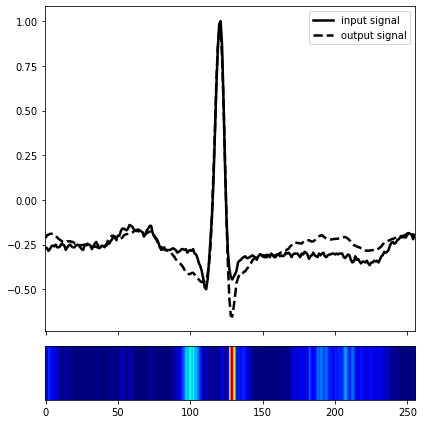

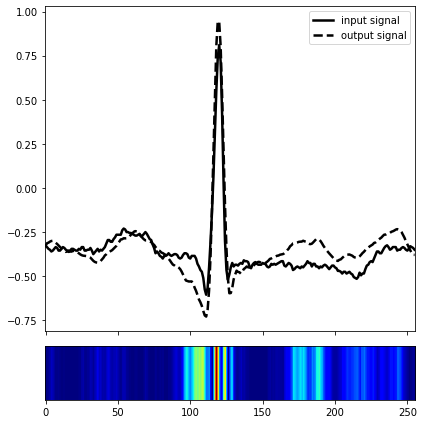

In [12]:
st.plot(st.BeatGAN, ori_ts[ind[0]], rec_ts[ind[0]], rec_err)
st.plot(st.BeatGAN, ori_ts[ind[-1]], rec_ts[ind[-1]], rec_err)

Deviate the least | Deviate the most
:-------------------------:|:-------------------------:
<img src="images/beatganRec1.png" width="300"/>  |   <img src="images/beatganRec2.png" width="300"/>
<b>Segment with maximum reconstruction error. |  <b>Segment with minimum reconstruction error.

### Run BeatGAN from train task to get a trained model

In [ ]:
train_task = st.Train.create(segments, st.TrainPolicy.BeatGAN, 'my_beatgan_model', network='CNN')

In [ ]:
train_task.run()

### Experiment Results
------
BeatGAN Structure      |  BeatGAN on Motion Datasets
:-------------------------:|:-------------------------:
<img src="images/beatganExp1.png" width="300"/>  |   <img src="images/beatganExp2.png" width="300"/>
<b>Structure of BeatGAN. |  <b>Beatlex reconstructs motion data.

|BeatGAN's fast inference|
|:-------------------------:|
|<img src="images/beatganExp3.png" width="300"/>|
|<b>BeatGAN has fast inference.|

### Cite:
------
1. Zhou, B., Liu, S., Hooi, B., Cheng, X., & Ye, J. (2019, August). BeatGAN: Anomalous Rhythm Detection using Adversarially Generated Time Series. In IJCAI (pp. 4433-4439).

    <details>
    <summary><span style="color:blue">click for BibTex...</span></summary>

    ```bibtex
    @inproceedings{zhou2019beatgan,
      title={BeatGAN: Anomalous Rhythm Detection using Adversarially Generated Time Series.},
      author={Zhou, Bin and Liu, Shenghua and Hooi, Bryan and Cheng, Xueqi and Ye, Jing},
      booktitle={IJCAI},
      pages={4433--4439},
      year={2019}
    }
    ```
    </details>